<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/dtrad/geoml_course/blob/master/PracticeSalt.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# TGS Salt Identification Kaggle Competition

For the salt identification, the list of files provided for this course are:

1. ./datasets/salt/seis -> seismic images for train dataset
2. ./datasets/salt/mask -> mask images for train dataset

The mask classifies each pixel of the seismic images as salt or not. So, this is a problem of object recognition, and an [Image Segmentation](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) may be the recommended method. For this, the Keras package will be used to create, train, and validate the model.

<img src="https://drive.google.com/uc?id=1lajGKOIqKJ2462ZfQIBTcHyaJ-B49bRH" width="1200" align="center">

# Convolutional Neural Network (CNN)

For images we typically use use [Convolutional Neural Networks](https://en.wikipedia.org/wiki/Convolutional_neural_network), or **CNN**. It is an algorithm that keep filtering the input images with convolutional windows and extracting important features from the images as deeper the network goes (the **encoder** part):

<img src="https://drive.google.com/uc?id=1tcB_ig1hHIObQiLxLUg9CChRmKJJ0UMp" width="1000" align="center">

In the figure above we see the structure of a CNN model. Each layer is composed of convolutional filters and activation functions, were the images are resampled to a lower resolution (for memory saving) and goes to the next layer, with another set of filters. In the end, fully connected layers are used to combine the extracted features and classify the image.

<img src="https://drive.google.com/uc?id=1tws2g-CF5A7lWyul_isHamObd_8XIEU9" width="350" align="center"><img src="https://drive.google.com/uc?id=11Xf44M-SysT7c3DlfVm0PHOcFwGmN2hv" width="450" align="center">

However, the problem above is to classify the whole image as an object, and that is not the type of solution we are looking for our project. We want to classify each pixel of the image as salt or not. We need a different strategy.


# U-Net for Image Segmentation

In the example below, we want to identify each object inside the image: car, bus, building, sidewalk, etc.

<img src="https://drive.google.com/uc?id=13CCtFQj76fLFd6NV-uVf_7WB4QQX-zLs" width="1400" align="center">

A simple CNN model is not enough to solve our problem. Instead, we are going to use an algorithim call [U-net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/), which is a variation of the CNN model. The difference is that the the fully connected layers are replace by the **decoder**:

<img src="https://drive.google.com/uc?id=16KGvbTDEzT5lpxA05oPWlp075OgAlUk9" width="1400" align="center">

Now the model can be represented by an **U** shaped design. The encoder and central part of the model are going to extract the features from the images, while the decoder, concatenated with the encoder, will start to localize the features inside the images. The output will be one matrix of probabilities with the same size of the input image, for each class of objects we want to identify.

<img src="https://drive.google.com/uc?id=1VjFRRspKEyzGaT1GoCCkK3IhyXjmqvup" width="1000" align="center">

For our *salt identification* problem, things are relatively simplified when compared to the exemple of the street image segmentation. Here the input are gray scale images, meaning that only one matrix will represent the image (if colored, 3 or 4 matrices would be required). Also, only one class is trying to be predicted (salt = 1), and the output will be only the matrix of probabilities for this class, where we will define the best threshold of probability to be classified as salt (1) or not (0).



In [13]:
import pandas as pd
import numpy as np
import os
import cv2      # ! pip install opencv-python (if package is not installed)
from random import *
from tensorflow.keras import Model, Input
from tensorflow.keras.models import load_model, save_model

from tensorflow.keras.layers import MaxPooling2D, Conv2D, BatchNormalization, Dropout, Conv2DTranspose

from tensorflow.keras.layers import concatenate
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline




In [52]:
if os.path.exists('datasets'):
    print('already unzipped')
else:
    os.system('unzip -f saltdata.zip')

already unzipped


Setting data folders names and list of training files.

In [15]:
TRAIN_IMAGE_DIR = './datasets/salt/seis/' #img_id is x(input)
TRAIN_MASK_DIR = './datasets/salt/mask/'   #rle_mask is y(output)

train_d = os.listdir(TRAIN_IMAGE_DIR)

Loading train data, figures and masks.

In [16]:
x = [np.array(cv2.imread(TRAIN_IMAGE_DIR + p, cv2.IMREAD_GRAYSCALE), dtype=np.uint8) for p in train_d]
x = np.array(x)/255

y = [np.array(cv2.imread(TRAIN_MASK_DIR + p, cv2.IMREAD_GRAYSCALE), dtype=np.uint8) for p in train_d]
y = np.array(y)/255
print(x.shape,y.shape)

(400, 101, 101) (400, 101, 101)


Resizing images for a power of 2 ($2^n$) to stabilize the U-net:

In [17]:
def resizeImage(img, size = 128):
    imgR = np.zeros((img.shape[0],size,size))
    for i in range(img.shape[0]):
        imgR[i] = cv2.resize(img[i],(size,size))
    return(imgR)

In [18]:
x = resizeImage(x)
y = resizeImage(y)

In [19]:
print(x.shape,y.shape)

(400, 128, 128) (400, 128, 128)


Ploting the images of seismic sessions and salt classification:

In [20]:
def plotImageTransp(file1, file2, k, alpha = 0.2):
    fig, ax = plt.subplots(nrows=k, ncols=k, figsize=(18, 18))
    for i in range(k):
        for j in range(k):
            ind = randint(0,file1.shape[0]-1)
            ax[i,j].imshow(file1[ind], cmap='Greys')
            ax[i,j].imshow(file2[ind], cmap='Greens', alpha = alpha)
            ax[i,j].set_axis_off()
    fig.subplots_adjust(wspace = -0.15, hspace = 0.02)
    return(fig)

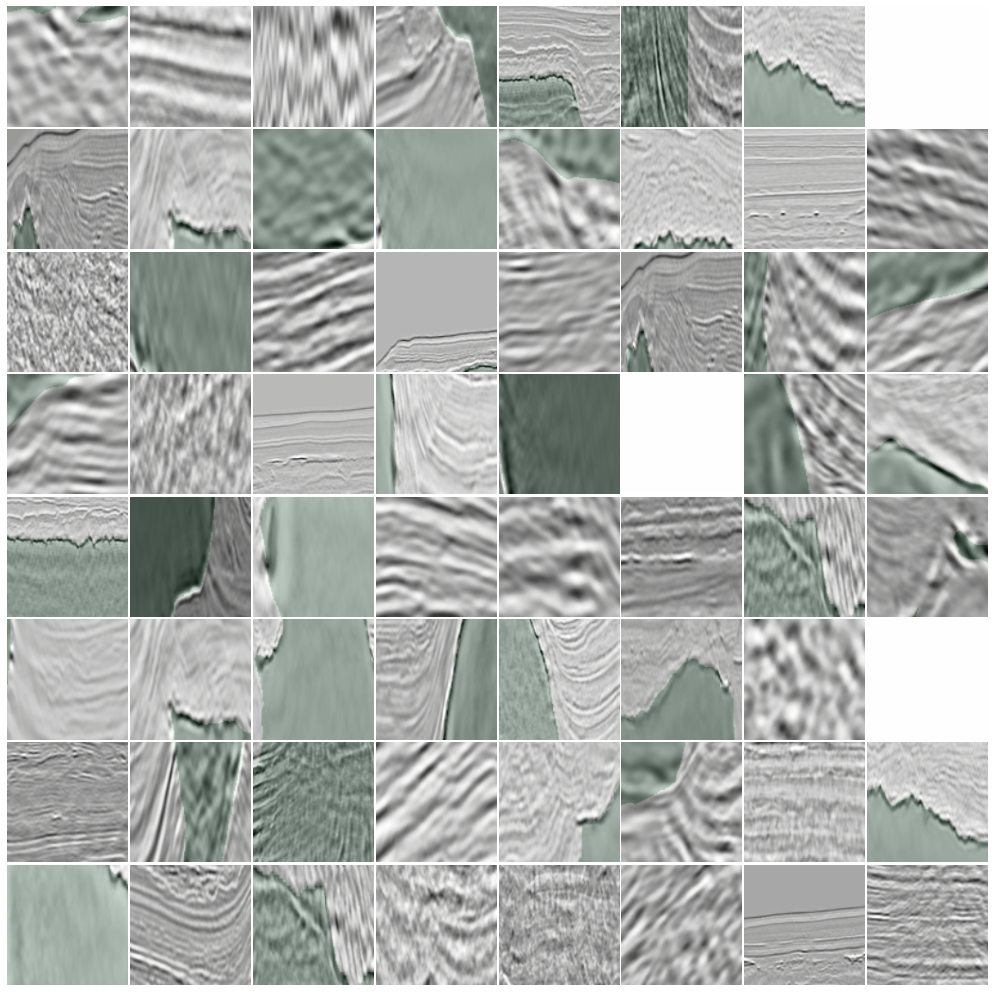

In [21]:
fig = plotImageTransp(x, y, k = 8)

In [22]:
x.shape, y.shape

((400, 128, 128), (400, 128, 128))

Expand arrays dimension for Keras:

In [23]:
x = np.expand_dims(x, axis = 3) #EXPAND DIM OF X AND INSERT NEW AXIS @ 3 
y = np.expand_dims(y, axis = 3)
print(x.shape, y.shape)

(400, 128, 128, 1) (400, 128, 128, 1)


### Spliting data into train and validation sets

In [24]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2, random_state = 666)
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

(320, 128, 128, 1) (320, 128, 128, 1) (80, 128, 128, 1) (80, 128, 128, 1)


### Data augmentation (run if you desire to, but it will require more computer power)

Create "new" images from the existent ones.

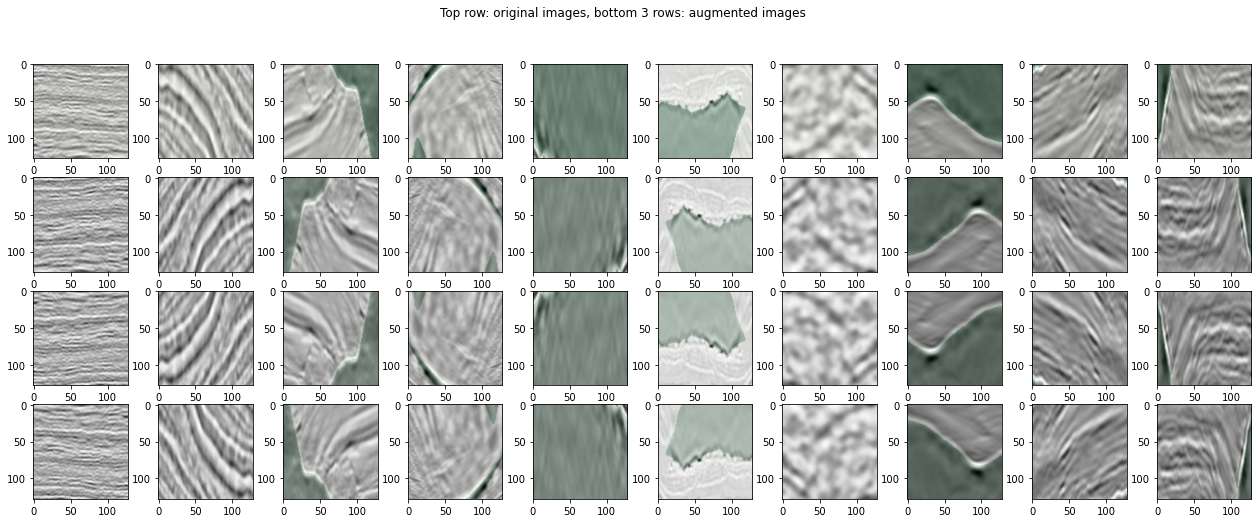

In [25]:
if 1:
    x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
    y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
    x_train = np.append(x_train, [np.flipud(x) for x in x_train], axis=0)
    y_train = np.append(y_train, [np.flipud(x) for x in y_train], axis=0)

    fig, axs = plt.subplots(4, 10, figsize=(22,8))
    for i in range(10):
        axs[0][i].imshow(x_train[i].squeeze(), cmap="Greys")
        axs[0][i].imshow(y_train[i].squeeze(), cmap="Greens", alpha=0.3)
        axs[1][i].imshow(x_train[int(len(x_train)/4 + i)].squeeze(), cmap="Greys")
        axs[1][i].imshow(y_train[int(len(y_train)/4 + i)].squeeze(), cmap="Greens", alpha=0.2)
        axs[2][i].imshow(x_train[int(len(x_train)/2 + i)].squeeze(), cmap="Greys")
        axs[2][i].imshow(y_train[int(len(y_train)/2 + i)].squeeze(), cmap="Greens", alpha=0.2)
        axs[3][i].imshow(x_train[int(len(x_train)/4*3 + i)].squeeze(), cmap="Greys")
        axs[3][i].imshow(y_train[int(len(y_train)/4*3 + i)].squeeze(), cmap="Greens", alpha=0.2)
    fig.suptitle("Top row: original images, bottom 3 rows: augmented images")



In [26]:
print(x_train.shape, y_train.shape)

(1280, 128, 128, 1) (1280, 128, 128, 1)


### Creating the *Keras* model

In [27]:
def unet_simple(input_size = (128,128,1)):

    inputs = Input(input_size)
    
    # 128
    conv1 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Center: 128 -> 64
    conv2 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    drop2 = Dropout(0.5)(conv2)

    # 64 -> 128
    up3 = Conv2DTranspose(2,(2,2),strides=(2,2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop2)
    up3 = BatchNormalization()(up3)
    merge3 = concatenate([conv1,up3],axis=3)
    conv3 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(1, 1, activation = 'sigmoid')(conv3)

    model = Model(inputs = inputs, outputs = conv4)

    return model

## Exercise

The `unet_simple()` it too simple. For a better training and predictions, you need to create a more complex model. So, create a model with the following instructions:

1. 4 convolutional layers for the *encoder* part, 1 layer for the *compressed representation*, and 4 more layers for the *decoder*
2. Each convolutional layer **MUST** contain at least 1 `Conv2D`, 1 `BatchNormalization`. Remember to include a `Conv2DTranspose` and a `concatenate` to the decoder layers.
3. Set the `padding` parameter of the `Conv2D` as 'same'.
4. *Optional*: include `Dropout` in some layers to avoid overfitting.

<img src="https://drive.google.com/uc?id=1VjFRRspKEyzGaT1GoCCkK3IhyXjmqvup" width="700" align="center">

In [28]:

def unet(input_size = (128,128,1)):

    inputs = Input(input_size)
    
    # YOUR CODE HERE #
    # Encoder layer 1
    

    # Encoder layer 2

    
    # Encoder layer 3

    
    # Encoder layer 4

    
    # Center (compressed representation)

    
    # Decoder layer 1

    
    # Decoder layer 2

    
    # Decoder layer 3

    
    # Decoder layer 4


    
    #output = Conv2D(1, 1, activation = 'sigmoid')(# your last tensor here)

    #model = Model(inputs = inputs, outputs = output)
    
    #return model
    

In [29]:
model = unet_simple()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 2)  20          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 2)  8           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 2)    0           batch_normalization[0][0]        
______________________________________________________________________________________________

2022-11-22 14:41:25.161346: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 14:41:26.400075: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10237 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:09:00.0, compute capability: 8.6
2022-11-22 14:41:26.400633: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 5636 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:05:00.0, compute capability: 7.5


Compile the model:

In [30]:
model.compile(loss = "binary_crossentropy", optimizer = "nadam", metrics = ["accuracy"])

The next cell code is how to fit the model. However, it will take too long, so:

In [31]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
monitor = "val_accuracy"
early_stopping = EarlyStopping(monitor = monitor, patience = 100, verbose = 1)
model_checkpoint = ModelCheckpoint("mymodel.model", monitor = monitor, save_best_only = True, verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = monitor, factor = 0.1, patience = 5, min_lr = 0.00000005, verbose = 1)
epochs = 20
batch_size = 20

In [32]:
history = model.fit(x_train, y_train,
                    validation_data = (x_valid, y_valid), 
                    epochs = epochs,
                    batch_size = batch_size,
                    callbacks = [early_stopping, model_checkpoint, reduce_lr],
                    verbose = 2)

2022-11-22 14:41:27.022020: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-11-22 14:41:29.242494: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


64/64 - 6s - loss: 0.6856 - accuracy: 0.7288 - val_loss: 0.6668 - val_accuracy: 0.7375

Epoch 00001: val_accuracy improved from -inf to 0.73752, saving model to mymodel.model


2022-11-22 14:41:34.352862: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: mymodel.model/assets
Epoch 2/20
64/64 - 0s - loss: 0.6513 - accuracy: 0.7563 - val_loss: 0.6383 - val_accuracy: 0.7375

Epoch 00002: val_accuracy improved from 0.73752 to 0.73752, saving model to mymodel.model
INFO:tensorflow:Assets written to: mymodel.model/assets
Epoch 3/20
64/64 - 0s - loss: 0.6196 - accuracy: 0.7564 - val_loss: 0.6130 - val_accuracy: 0.7375

Epoch 00003: val_accuracy did not improve from 0.73752
Epoch 4/20
64/64 - 0s - loss: 0.5942 - accuracy: 0.7565 - val_loss: 0.5942 - val_accuracy: 0.7375

Epoch 00004: val_accuracy did not improve from 0.73752
Epoch 5/20
64/64 - 0s - loss: 0.5754 - accuracy: 0.7565 - val_loss: 0.5819 - val_accuracy: 0.7375

Epoch 00005: val_accuracy did not improve from 0.73752
Epoch 6/20
64/64 - 0s - loss: 0.5633 - accuracy: 0.7565 - val_loss: 0.5752 - val_accuracy: 0.7375

Epoch 00006: val_accuracy did not improve from 0.73752

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
E

In [33]:
historypd = pd.DataFrame(history.history)
historypd

loss  accuracy  val_loss  val_accuracy        lr
0   0.685561  0.728814  0.666757      0.737516  0.001000
1   0.651260  0.756301  0.638293      0.737518  0.001000
2   0.619576  0.756412  0.612991      0.737518  0.001000
3   0.594158  0.756488  0.594232      0.737518  0.001000
4   0.575397  0.756529  0.581936      0.737518  0.001000
5   0.563270  0.756547  0.575179      0.737518  0.001000
6   0.559207  0.756143  0.574752      0.737518  0.000100
7   0.558112  0.756550  0.574354      0.737518  0.000100
8   0.557534  0.756550  0.573994      0.737518  0.000100
9   0.556975  0.756550  0.573665      0.737518  0.000100
10  0.556434  0.756550  0.573374      0.737518  0.000100
11  0.556153  0.756550  0.573365      0.737518  0.000010
12  0.556134  0.756525  0.573349      0.737516  0.000010
13  0.556059  0.756537  0.573332      0.737516  0.000010
14  0.556000  0.756549  0.573311      0.737516  0.000010
15  0.555966  0.756550  0.573285      0.737516  0.000010
16  0.555920  0.756550  0.573289      0.737516  0.000001
17  0.555898  0.756550  0.573288      0.737516  0.000001
18  0.555913  0.756538  0.573287      0.737516  0.000001
19  0.555894  0.756550  0.573280      0.737516  0.000001

<AxesSubplot:>

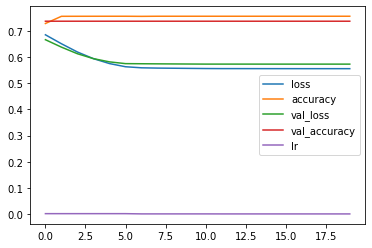

In [34]:
historypd.plot()

## $$\text{If you don't want to wait the cell above to run, skip it and uncomment the next cell to load a saved (and better) model)!!!}$$

Loading performance *history* and pre-trained *model*.

In [35]:
# history = pd.read_csv('history.csv', index_col = 0)
# model = load_model("./keras.model")
# model.summary()

Let's check how the model was trained.

### Predictions on the validation sets

In [36]:
!ls -lah ./mymodel.model

total 424K
drwxr-xr-x.  4 dtrad dtrad  100 Nov 22 14:41 .
drwxrwxr-x. 12 dtrad dtrad 4.0K Nov 22 14:31 ..
drwxr-xr-x.  2 dtrad dtrad   10 Nov 22 13:08 assets
-rw-rw-r--.  1 dtrad dtrad  31K Nov 22 14:41 keras_metadata.pb
-rw-rw-r--.  1 dtrad dtrad 388K Nov 22 14:41 saved_model.pb
drwxr-xr-x.  2 dtrad dtrad   76 Nov 22 14:41 variables


In [37]:
model = load_model("./mymodel.model")

In [39]:
#model = load_model("./keras.model")

In [40]:
preds_valid = model.predict(x_valid)
preds_valid = resizeImage(preds_valid[:,:,:,0], size = 101)
y_valid_ori = resizeImage(y_valid[:,:,:,0], size = 101)
x_valid_ori = resizeImage(x_valid[:,:,:,0], size = 101)

In [41]:
def plotImageTranspValid(file1, file2, file3, k, alpha1 = 0.2, alpha2 = 0.2):
    fig, ax = plt.subplots(nrows=k, ncols=k, figsize=(18, 18))
    for i in range(k):
        for j in range(k):
            ind = randint(0,file1.shape[0]-1)
            ax[i,j].imshow(file1[ind], cmap='Greys')
            ax[i,j].imshow(file2[ind], cmap='Greens', alpha = alpha1)
            ax[i,j].imshow(file3[ind], cmap='Reds', alpha = alpha2)
            ax[i,j].set_axis_off()
    fig.subplots_adjust(wspace = -0.15, hspace = 0.02)
    plt.suptitle("Green: salt, Red: prediction.")
    return(fig)

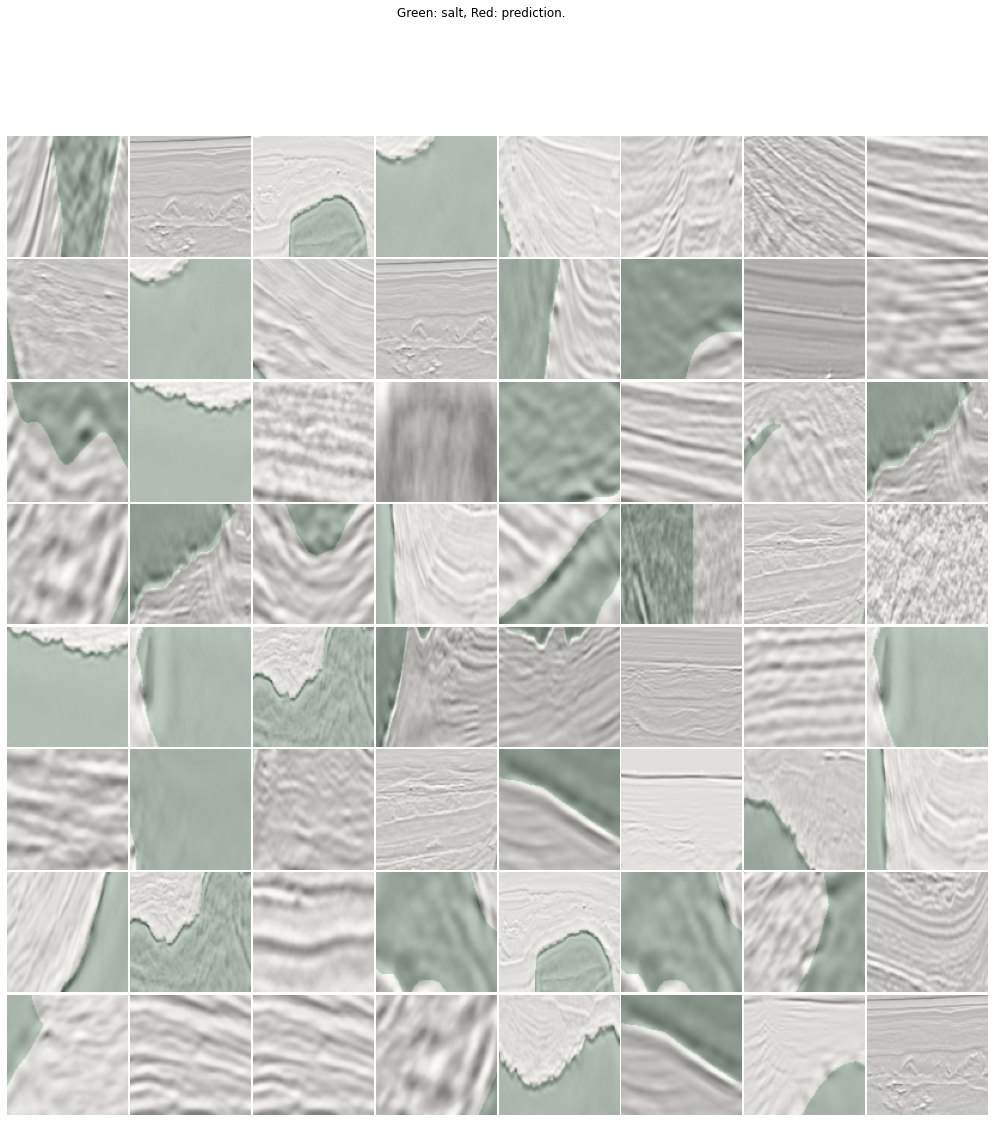

In [42]:
fig = plotImageTranspValid(x_valid_ori, y_valid_ori, np.round(preds_valid), k = 8, alpha1 = 0.3, alpha2 = 0.3)

### Scoring Metric

Score the model predictions and select an optimized threshold. Using the [IoU](https://en.wikipedia.org/wiki/Jaccard_index) (intersection over union) score metric.

<img src="https://drive.google.com/uc?id=1ISt6kdojCNHKJujTfzVJ3ijlytmZRRpR" width="500" width="500" align="center">


In [43]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [44]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in thresholds])

In [45]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

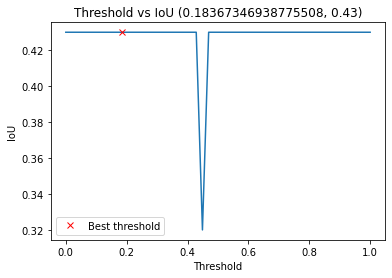

In [46]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

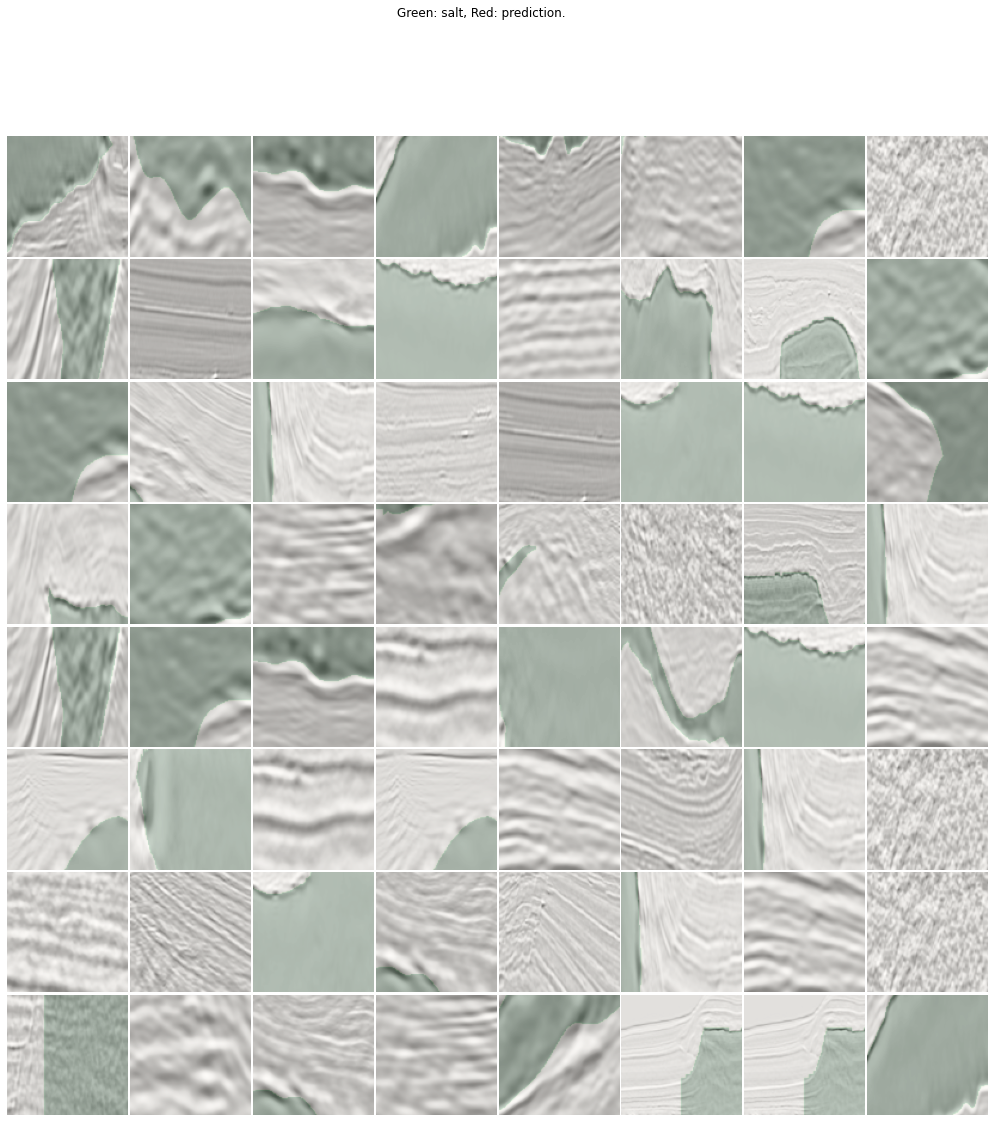

In [47]:
fig = plotImageTranspValid(x_valid_ori, y_valid_ori, np.int32(preds_valid > threshold_best), k = 8, alpha1 = 0.3, alpha2 = 0.3)

Below is the prediction we got for the competition and our score was $0.837$.

<img src="https://drive.google.com/uc?id=1R0S9K2j3ePT3hiBONuqBJCJyjGmAwOnF" width="1400" align="center">